In [1]:
import torch
import numpy as np
from models import Discriminator_MLP_Skip_OLD, Generater_MLP_Skip_OLD
from data_PET import read_data, get_data_loaders

# Load data
uPiB, uFBP, pPiB, pFBP, uPiB_CL, uFBP_CL, uPiB_scaler, uFBP_scaler = read_data(normalize=False)
val_dataloader, dataloader = get_data_loaders(uPiB, uFBP, pPiB, pFBP, uPiB_CL, uFBP_CL, 
                                                  46, resample='matching')

model_FBP_path = './training_logs_matching_mc_l2/saved_model/160_160_8_10_1_10.0_5.0_5.0/D_A_Best.pth'
model_PiB_path = './training_logs_matching_mc_l2/saved_model/160_160_8_10_1_10.0_5.0_5.0/D_B_Best.pth'
model_PiB_gen_path = './training_logs_matching_mc_l2/saved_model/160_160_8_10_1_10.0_5.0_5.0/G_AB_Best.pth'
model_FBP_gen_path = './training_logs_matching_mc_l2/saved_model/160_160_8_10_1_10.0_5.0_5.0/G_BA_Best.pth'

pFBP_fake = torch.load('./training_logs_matching_mc_l2/data/160_160_8_10_1_10.0_5.0_5.0/fake_A_Best.pt')
pPiB_fake = torch.load('./training_logs_matching_mc_l2/data/160_160_8_10_1_10.0_5.0_5.0/fake_B_Best.pt')

Gen_FBP = Generater_MLP_Skip_OLD(85, 160, 85, 8)
Gen_PiB = Generater_MLP_Skip_OLD(85, 160, 85, 8)
Gen_FBP.load_state_dict(torch.load(model_FBP_gen_path))
Gen_PiB.load_state_dict(torch.load(model_PiB_gen_path))
Gen_FBP.eval()
Gen_PiB.eval()

Dis_FBP = Discriminator_MLP_Skip_OLD(85, 160, 10)
Dis_PiB = Discriminator_MLP_Skip_OLD(85, 160, 10)
Dis_FBP.load_state_dict(torch.load(model_FBP_path))
Dis_PiB.load_state_dict(torch.load(model_PiB_path))
Dis_FBP.eval()
Dis_PiB.eval()


# combine real uPiB and uFBP as one dataset uPiB with label 0 and uFBP with label 1
uPiB = torch.tensor(uPiB).float()
uFBP = torch.tensor(uFBP).float()
Data_cls_real = torch.cat((uPiB, uFBP))
label_cls_real = torch.cat((torch.zeros(uPiB.shape[0]), torch.ones(uFBP.shape[0])))
print(Data_cls_real.shape)

pPiB = torch.tensor(pPiB).float()
pFBP = torch.tensor(pFBP).float()
Data_cls_real_test = torch.cat((pPiB, pFBP))
label_cls_real_test = torch.cat((torch.zeros(pPiB.shape[0]), torch.ones(pFBP.shape[0])))
print(Data_cls_real_test.shape)

# data loader_real 
train_data_real = torch.utils.data.TensorDataset(Data_cls_real, label_cls_real)
train_loader_real = torch.utils.data.DataLoader(train_data_real, batch_size=128, shuffle=True)
test_data_real = torch.utils.data.TensorDataset(Data_cls_real_test, label_cls_real_test)
test_loader_real = torch.utils.data.DataLoader(test_data_real, batch_size=128, shuffle=False)

# # get fake training data
uPiB_fake = Gen_PiB(uFBP)
uFBP_fake = Gen_FBP(uPiB)
uPiB_fake = uPiB_fake.detach()
uFBP_fake = uFBP_fake.detach()
# Data_cls_fake = torch.cat((uPiB_fake, uFBP_fake))
# label_cls_fake = torch.cat((torch.zeros(uPiB_fake.shape[0]), torch.ones(uFBP_fake.shape[0])))
# # get fake testing data
# Data_cls_fake_test = torch.cat((pPiB_fake, pFBP_fake))
# label_cls_fake_test = torch.cat((torch.zeros(pPiB_fake.shape[0]), torch.ones(pFBP_fake.shape[0])))

# data loader_fake_real
train_data_fake_real_PiB = torch.cat((uPiB, uPiB_fake))
label_fake_real_PiB = torch.cat((torch.ones(uPiB.shape[0]), torch.zeros(uPiB_fake.shape[0])))
train_data_fake_real_PiB = torch.utils.data.TensorDataset(train_data_fake_real_PiB, label_fake_real_PiB)
train_loader_fake_real_PiB = torch.utils.data.DataLoader(train_data_fake_real_PiB, batch_size=128, shuffle=True)

test_data_fake_real_PiB = torch.cat((pPiB, pPiB_fake))
label_fake_real_PiB_test = torch.cat((torch.ones(pPiB.shape[0]), torch.zeros(pPiB_fake.shape[0])))
test_data_fake_real_PiB = torch.utils.data.TensorDataset(test_data_fake_real_PiB, label_fake_real_PiB_test)
test_loader_fake_real_PiB = torch.utils.data.DataLoader(test_data_fake_real_PiB, batch_size=128, shuffle=False)




torch.Size([4674, 85])
torch.Size([92, 85])


In [15]:
from MCSUVR import cal_MCSUVR_torch, load_weights, cal_correlation
MCSUVR_WEIGHT, _, REGION_INDEX = load_weights()
mc_true = cal_MCSUVR_torch(pPiB,  REGION_INDEX, MCSUVR_WEIGHT).detach().numpy()
mc_fake = cal_MCSUVR_torch(pPiB_fake,  REGION_INDEX, MCSUVR_WEIGHT).detach().numpy()
cor = cal_correlation(mc_true, mc_fake)


import pandas as pd
pCL = pd.read_excel('./data_PET/Centioid_Summary.xlsx', sheet_name='Sheet1')

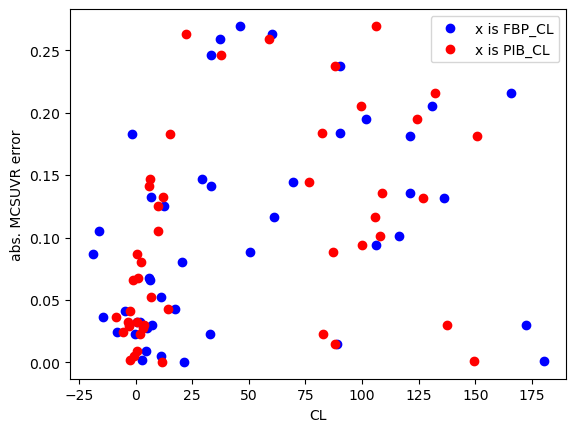

In [37]:
import matplotlib.pyplot as plt
plt.plot(pCL['FBP_CL'], np.abs((mc_true - mc_fake)), 'bo', label='x is FBP_CL')
plt.plot(pCL['PIB_CL'], np.abs((mc_true - mc_fake)), 'ro', label='x is PIB_CL')
plt.xlabel('CL')
plt.ylabel('abs. MCSUVR error')
plt.legend()
plt.savefig('./saved_mis/MC_error')

(array([ 8., 14.,  6.,  3.,  2.,  3.,  3.,  4.,  0.,  3.]),
 array([-18.950219 ,   0.9696411,  20.8895012,  40.8093613,  60.7292214,
         80.6490815, 100.5689416, 120.4888017, 140.4086618, 160.3285219,
        180.248382 ]),
 <BarContainer object of 10 artists>)

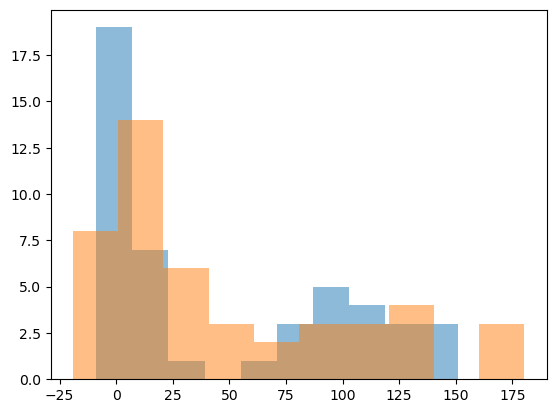

In [23]:
plt.hist(pCL['PIB_CL'], alpha=0.5)
plt.hist(pCL['FBP_CL'], alpha=0.5)

## Train a new CLS on real PiB and FBP data to directly differentiate between them

In [ ]:
Dis_NEW_real = Discriminator_MLP_Skip_OLD(85, 128, 8)
# train the new discriminator
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(Dis_NEW_real.parameters(), lr=0.0001)
num_epochs = 100

for epoch in range(num_epochs):
    Dis_NEW_real.train()
    for i, (images, labels) in enumerate(train_loader_real):
        outputs = Dis_NEW_real(images)
        loss = criterion(outputs.ravel(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Dis_NEW_real.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader_real:
            outputs = Dis_NEW_real(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.ravel() == labels).sum().item()
        
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Accuracy: {:.4f}'.format(epoch+1, num_epochs, correct/total))
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


In [ ]:
Dis_NEW_fake_real_PiB = Discriminator_MLP_Skip(85, 128, 2)
# train the new discriminator
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(Dis_NEW_fake_real_PiB.parameters(), lr=0.0001)
num_epochs = 100

for epoch in range(num_epochs):
    Dis_NEW_fake_real_PiB.train()
    for data, label in train_loader_fake_real_PiB:
        outputs = Dis_NEW_fake_real_PiB(data)
        loss = criterion(outputs.ravel(), label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Dis_NEW_fake_real_PiB.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in test_loader_fake_real_PiB:
            outputs = Dis_NEW_fake_real_PiB(data)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.ravel() == labels).sum().item()
    
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Accuracy: {:.4f}'.format(epoch+1, num_epochs, correct/total))
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

## Discriminator evaluation on real and fake data

In [ ]:
# classification real
p_FBP_FBP = Dis_FBP(pFBP)
p_FBP_PiB = Dis_FBP(pPiB)

p_PiB_FBP = Dis_PiB(pFBP)
p_PiB_PiB = Dis_PiB(pPiB)

acc_FBP_FBP = (p_FBP_FBP > 0.5).sum().item() / p_FBP_FBP.size(0)
acc_PiB_PiB = (p_PiB_PiB > 0.5).sum().item() / p_PiB_PiB.size(0)
acc_PiB_FBP = (p_PiB_FBP < 0.5).sum().item() / p_PiB_FBP.size(0)
acc_FBP_PiB = (p_FBP_PiB < 0.5).sum().item() / p_FBP_PiB.size(0)
print('FBP_FBP: ', acc_FBP_FBP, 'PiB_PiB: ', acc_PiB_PiB, 'PiB_FBP: ', acc_PiB_FBP, 'FBP_PiB: ', acc_FBP_PiB)
print('FBP_FBP_Prob: ', p_FBP_FBP.mean().item(), 'PiB_PiB_Prob: ', p_PiB_PiB.mean().item(), 'PiB_FBP_Prob: ', p_PiB_FBP.mean().item(), 'FBP_PiB_Prob: ', p_FBP_PiB.mean().item())

# classification fake
p_FBP_FBP = Dis_FBP(pFBP_fake)
p_FBP_PiB = Dis_FBP(pPiB_fake)
p_PiB_FBP = Dis_PiB(pFBP_fake)
p_PiB_PiB = Dis_PiB(pPiB_fake)

acc_FBP_FBP = (p_FBP_FBP > 0.5).sum().item() / p_FBP_FBP.size(0)
acc_PiB_PiB = (p_PiB_PiB > 0.5).sum().item() / p_PiB_PiB.size(0)
acc_PiB_FBP = (p_PiB_FBP < 0.5).sum().item() / p_PiB_FBP.size(0)
acc_FBP_PiB = (p_FBP_PiB < 0.5).sum().item() / p_FBP_PiB.size(0)
print('FBP_FBP: ', acc_FBP_FBP, 'PiB_PiB: ', acc_PiB_PiB, 'PiB_FBP: ', acc_PiB_FBP, 'FBP_PiB: ', acc_FBP_PiB)
print('FBP_FBP_Prob: ', p_FBP_FBP.mean().item(), 'PiB_PiB_Prob: ', p_PiB_PiB.mean().item(), 'PiB_FBP_Prob: ', p_PiB_FBP.mean().item(), 'FBP_PiB_Prob: ', p_FBP_PiB.mean().item())

|Model|Dataset|Accuracy|ave_Prob|
|:----|:------|:------:|:------:|
|Dis_FBP|Real_FBP|0.46|0.50|
|Dis_FBP|Fake_FBP|0.39|0.50|
|Dis_FBP|Real_PiB|**0.78**|0.48|
|Dis_FBP|Fake_PiB|**0.48**|0.50|
|----|------|------|--------|
|Dis_PiB|Real_PiB|0.39|0.47|
|Dis_PiB|Fake_PiB|0.26|0.47|
|Dis_PiB|Real_FBP|**0.91**|0.42|
|Dis_PiB|Fake_FBP|**0.87**|0.38|


## New real classifier evaluation on real data

In [ ]:

p_FBP_real = Dis_NEW_real(pFBP)
p_PiB_real = Dis_NEW_real(pPiB)
p_FBP_fake = Dis_NEW_real(pFBP_fake)
p_PiB_fake = Dis_NEW_real(pPiB_fake)

acc_FBP_real = (p_FBP_real > 0.5).sum().item() / p_FBP_real.size(0)
acc_PiB_real = (p_PiB_real < 0.5).sum().item() / p_PiB_real.size(0)
acc_FBP_fake = (p_FBP_fake > 0.5).sum().item() / p_FBP_fake.size(0)
acc_PiB_fake = (p_PiB_fake < 0.5).sum().item() / p_PiB_fake.size(0)

print('FBP_real: ', acc_FBP_real, 'PiB_real: ', acc_PiB_real, 'FBP_fake: ', acc_FBP_fake, 'PiB_fake: ', acc_PiB_fake)


In [ ]:
p_PiB_FBP_real = Dis_NEW_fake_real_PiB(pFBP)
p_PiB_PiB_real = Dis_NEW_fake_real_PiB(pPiB)
p_PiB_FBP_fake = Dis_NEW_fake_real_PiB(pFBP_fake)
p_PiB_PiB_fake = Dis_NEW_fake_real_PiB(pPiB_fake)

acc_FBP_real = (p_PiB_FBP_real < 0.5).sum().item() / pFBP.size(0)
acc_PiB_real = (p_PiB_PiB_real > 0.5).sum().item() / pPiB.size(0)
acc_FBP_fake = (p_PiB_FBP_fake < 0.5).sum().item() / pFBP_fake.size(0)
acc_PiB_fake = (p_PiB_FBP_fake > 0.5).sum().item() / pPiB_fake.size(0)

print('FBP_real: ', acc_FBP_real, 'PiB_real: ', acc_PiB_real, 'FBP_fake: ', acc_FBP_fake, 'PiB_fake: ', acc_PiB_fake)


In [ ]:
import shap
shap.initjs()

def f(X):
    X = torch.tensor(X, dtype=torch.float32)
    p = Dis_NEW(X)
    return p.detach().numpy()

for data in test_loader:
    data_shap, _ = data
explainer = shap.Explainer(f, data_shap.numpy())
shap_values = explainer(data_shap.numpy())
shap.plots.beeswarm(shap_values)

In [19]:
# import matplotlib.pyplot as plt
# p_PiB_PiB_np = p_PiB_PiB.detach().numpy()
# p_PiB_FBP_np = p_PiB_FBP.detach().numpy()
# p_FBP_FBP_np = p_FBP_FBP.detach().numpy()
# p_FBP_PiB_np = p_FBP_PiB.detach().numpy()

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# ax[0].plot(p_PiB_PiB_np, 'ro', label='PiB data')
# ax[0].plot(p_PiB_FBP_np, 'bo', label='FBP data')
# ax[0].set_xlabel('Sample Index')
# ax[0].set_ylabel('Probability')
# ax[0].legend()
# ax[0].set_title('PiB Discriminator')

# ax[1].plot(p_FBP_PiB_np, 'ro', label='PiB data')
# ax[1].plot(p_FBP_FBP_np, 'bo', label='FBP data')
# ax[1].set_xlabel('Sample Index')
# ax[1].set_ylabel('Probability')
# ax[1].legend()
# ax[1].set_title('FBP Discriminator')